## Import all required packages.

In [ ]:
import tensorflow as tf
import os, shutil
import pandas
import random
import numpy as np
import cv2
import glob
import pathlib
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

## Download the dataset.



*   Download dataset from a site using get_file() method.
*   Extract the zip(tar) file.
*   Save the path into a variable.


In [ ]:
data_dir= tf.keras.utils.get_file("CUB_200_2011", origin='https://data.caltech.edu/tindfiles/serve/1239ea37-e132-42ee-8c09-c383bb54e7ff/', untar=True)

In [ ]:
image_dir = data_dir + '/images/' # Save path of image directory.
folders_data = pandas.read_table(data_dir + '/classes.txt', sep = ' ', names = ['id', 'classes']) # Save data of classes.

## Print some sample images.

C:\Users\c21065793\.keras\datasets\CUB_200_2011/images/186.Cedar_Waxwing/*


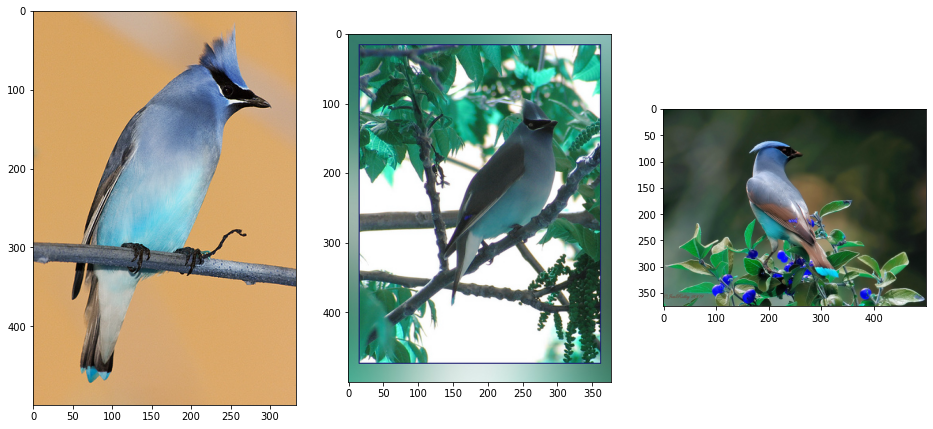

In [ ]:
plt.figure(figsize=(16,16))
first = image_dir + random.sample(os.listdir(image_dir),1)[0] + '/*' # Take any random folder for printing sample images.
print(first)
images = glob.glob(first)
sample = random.sample(images, 3)
plt.subplot(131)
plt.imshow(cv2.imread(sample[0]))
plt.subplot(132)
plt.imshow(cv2.imread(sample[1]))
plt.subplot(133)
plt.imshow(cv2.imread(sample[2]))

## Data augmentation:
We increase the size of the dataset so that training can be more reliable. 

> Using cv2 library images are flipped horizontally and gausian blue applied to them. 
> This way we get 4 times the size of the original dataset.
> Images are then converted into numpy arrays and labels are made categorical.

In [ ]:
images= []
labels= []
# Traverse through the folders and process an image one by one.
for i, folder in folders_data.iterrows(): 
  bird_dir = image_dir + '/' + folder.classes 
  for image in sorted(os.listdir(bird_dir)):
    current_img = cv2.imread(bird_dir + '/' + image) # Read the image.
    current_img = cv2.resize(current_img, (75,75), interpolation= cv2.INTER_AREA) # Resize the image to (75,75) using INTER_AREA method to keep all the features.
    images.append(current_img)
    labels.append(folder.id)
    current_img1 = cv2.flip(current_img, flipCode=1) # Flip image horizontally.
    images.append(current_img1)
    labels.append(folder.id)
    current_img2 = cv2.GaussianBlur(current_img, (7,7), 0) # Apply Gaussian blur on original image.
    images.append(current_img2)
    labels.append(folder.id)
    current_img3 = cv2.GaussianBlur(current_img1, (7,7), 0) # Apply gaussian blur on flipped image.
    images.append(current_img3)
    labels.append(folder.id)

images = np.array(images) # Convert images to numpy arrays.
labels = to_categorical(labels) # Make labels categorical.

## Splitting the dataset:

> For this implementation as we have plenty of images only 5% of the data is taken for test data set.
> Spliting is done based on stratified labels thus data stays balanced after splitting.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(images, labels, test_size=0.05, random_state= 5, shuffle= True, stratify= labels) 

Additional augmentation on images.

In [ ]:
train_data = ImageDataGenerator(rescale=1./255,
                                featurewise_center=True,
                                samplewise_center=True,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True,
                                horizontal_flip=True,
                                rotation_range= 0.2,
                                dtype= np.float32
                                )
train_data.fit(X_train)

In [ ]:
test_data = ImageDataGenerator(rescale=1./255,
                                featurewise_center=True,
                                samplewise_center=True,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True,
                                horizontal_flip=True,
                                rotation_range= 0.2,
                                dtype= np.float32
                                )
test_data.fit(X_test)

## Design a model.

> Use CNN for better accuracy.
> 6 Convoluted layers and 2 Dense layers are used in the design.
> For stopping the model from overfitting Batch normalization layer, Dropout layer and L2 regularizer is used.

In [ ]:
model=Sequential()

model.add(Conv2D(8, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (75,75,3)))
model.add(Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(3))

model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(3))

model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(3))

model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(201, activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

## Complie model.

In [ ]:
model.compile(optimizer= 'adam', loss = categorical_crossentropy, metrics = ['accuracy'])

## Fit the model.
> From the remaining 95% dataset, take roughly 15% for validation set and fit the designed model on both.

In [ ]:
history=model.fit(X_train, y_train, epochs=50, verbose= 1, validation_split= 0.175, batch_size= 32, shuffle= True)

Epoch 1/50
1155/1155 [==============================] - 191s 165ms/step - loss: 5.5456 - accuracy: 0.0178 - val_loss: 4.9603 - val_accuracy: 0.0339
Epoch 2/50
1155/1155 [==============================] - 234s 203ms/step - loss: 4.6085 - accuracy: 0.0642 - val_loss: 4.2276 - val_accuracy: 0.1130
Epoch 3/50
1155/1155 [==============================] - 239s 207ms/step - loss: 4.1177 - accuracy: 0.1315 - val_loss: 3.9872 - val_accuracy: 0.1695
Epoch 4/50
1155/1155 [==============================] - 266s 231ms/step - loss: 3.8825 - accuracy: 0.1821 - val_loss: 3.6864 - val_accuracy: 0.2148
Epoch 5/50
1155/1155 [==============================] - 252s 218ms/step - loss: 3.5392 - accuracy: 0.2509 - val_loss: 3.4608 - val_accuracy: 0.2792
Epoch 6/50
1155/1155 [==============================] - 239s 207ms/step - loss: 3.5220 - accuracy: 0.2687 - val_loss: 3.6606 - val_accuracy: 0.2780
Epoch 7/50
1155/1155 [==============================] - 255s 221ms/step - loss: 3.1816 - accuracy: 0.3344 - val_

## Evaluate model using test set.

In [ ]:
evaluate_model = model.evaluate(X_test, y_test)

74/74 [==============================] - 3s 45ms/step - loss: 2.4452 - accuracy: 0.8278


## Plot a graph.
> Using the saved history of the model, plot the graph of accuracy and loss.

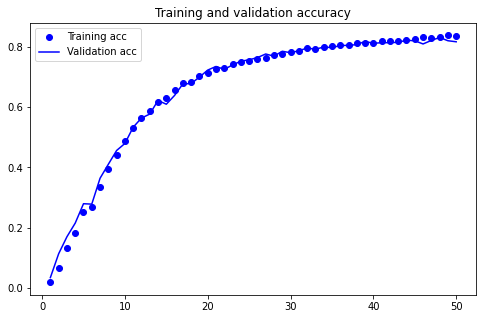

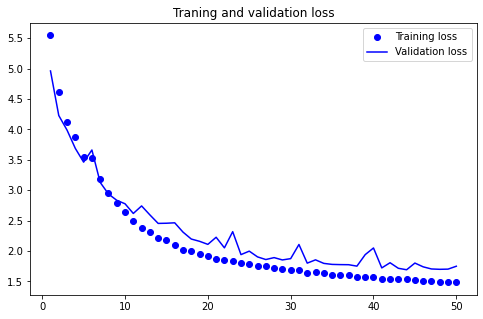

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.figure(figsize= (8,5))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize= (8,5))

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

## Finally print the results.
> Calculate precision, recall, f1 score, accuracy of the model.

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

print('Metrics calculation of the model:\n-----------------------------\n')

print('Precision: %.2f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.2f' % recall_score(y_test, y_pred, average='weighted'))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.2f' % f1_score(y_test, y_pred, average='weighted'))

Metrics calculation of the model:
-----------------------------

Precision: 0.85
Recall: 0.83
Accuracy: 0.83
F1 Score: 0.83


In [ ]:
# Print classification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.67      0.50      0.57        12
           3       0.83      0.45      0.59        11
           4       0.92      1.00      0.96        12
           5       1.00      0.78      0.88         9
           6       0.78      0.88      0.82         8
           7       0.77      1.00      0.87        10
           8       0.64      0.78      0.70         9
           9       0.85      0.92      0.88        12
          10       0.85      0.92      0.88        12
          11       0.67      0.67      0.67        12
          12       0.92      1.00      0.96        11
          13       0.79      0.92      0.85        12
          14       0.75      1.00      0.86        12
          15       0.83      0.91      0.87        11
          16       0.92      1.00      0.96        11
          17       0.75      0.82      0.78        11
          18       0.75    